# APIs

In [29]:
import shutil
import os

for path in ['cache_dir/', '__pycache__/', 'custom_transformers/__pycache__/']:
    if os.path.exists(path):
        shutil.rmtree(path)

from joblib import Memory
memory = Memory(location='cache_dir', verbose=0)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, skew
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, learning_curve, LearningCurveDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures, MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest

from xgboost import XGBRegressor
# %pip install xgboost

from preprocessing_function import convert_to_str, log_transform, exp_transform
from custom_transformers import EngineSizeTransformer, MultiLabelBinarizerTransformer, YearTransformer
import pickling_checker

# %pip install pypalettes
from pypalettes import load_cmap

import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)

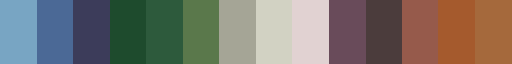

In [3]:
cmap = load_cmap('fleurs_dans_un_vase_de_cristal')
cmap

In [4]:
print(cmap.colors[4])

#2D5A3CFF


# Setup data

## Load train data

In [5]:
train_csv = pd.read_csv('data/train.csv')

In [6]:
train_csv.shape

(7478, 33)

Drop rows with all null values, and extreme outliers

In [7]:
train_csv.iloc[[175, 913, 7067, 508, 5789], :]

,Id,Scraped_Time,Condition,Car Make,Model,Trim,Year,Kilometers,Body Type,Number of Seats,...,Neighborhood,Category,Subcategory,Interior Options,Exterior Options,Technology Options,Description_Score,Battery Capacity,Battery Range,Price
175,176,2025-02-07 12:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Khalda,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1750.0
913,914,2025-02-07 12:52:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Russayfah,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
7067,7068,2025-02-07 13:20:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Al Hay Al Sharqy,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1250.0
508,509,2025-02-07 00:50:31,Used,Chevrolet,Cruze,Standard,2010,"80,000 - 89,999",Sedan,5,...,Tla' Ali,Cars and Bikes,Cars For Sale,"AUX / USB Input, Steering Wheel Controls, Elec...","Spare Tyre, Electric Mirrors","Android Auto, Bluetooth, Touch Screen, Media S...",NaN,NaN,NaN,1000000.0
5789,5790,2025-02-06 21:19:43,Used,Toyota,Hiace,Cargo,1991,"130,000 - 139,999",Bus - Van,9,...,Dayr Yusuf,Cars and Bikes,Cars For Sale,Airbags,Back Hook,Navigation system / maps,NaN,NaN,NaN,999999.0


In [8]:
train_csv.drop(index=[175, 913, 7067, 508, 5789], inplace=True)

In [9]:
train_csv.shape

(7473, 33)

## Update Column Names

In [10]:
cols_map = {'Id': 'id', 'Scraped_Time': 'scraped_time', 'Condition': 'condition', 
            'Car Make': 'car_make', 'Model': 'model', 'Trim': 'trim', 'Year': 'year', 
            'Kilometers': 'kilometers', 'Body Type': 'body_type', 'Number of Seats': 'num_of_seats', 
            'Fuel': 'fuel', 'Transmission': 'transmission', 'Engine Size (cc)': 'engine_size_cc', 
            'Exterior Color': 'exterior_color', 'Interior Color': 'interior_color', 
            'Regional Specs': 'regional_specs', 'Car License': 'car_license', 'Insurance': 'insurance', 
            'Car Customs': 'car_customs', 'Body Condition': 'body_condition', 'Paint': 'paint', 
            'Payment Method': 'payment_method', 'City': 'city', 'Neighborhood': 'neighborhood', 
            'Category': 'category', 'Subcategory': 'subcategory', 'Interior Options': 'interior_options', 
            'Exterior Options': 'exterior_options', 'Technology Options': 'technology_options', 
            'Description_Score': 'description_score', 'Battery Capacity': 'battery_capacity', 
            'Battery Range': 'battery_range', 'Price': 'price'}

In [11]:
train_csv.rename(columns=cols_map, inplace=True)
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

## Splitting Train data into Training, Validation and Test sets

In [12]:
target = 'price'
y = train_csv[target]
X = train_csv.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, shuffle=True, test_size=0.15)

In [13]:
print(f'Shape of train set: {X_train.shape, y_train.shape}')
print(f'Shape of val set  : {X_val.shape, y_val.shape}')
print(f'Shape of test set : {X_test.shape, y_test.shape}')

Shape of train set: ((5399, 32), (5399,))
Shape of val set  : ((953, 32), (953,))
Shape of test set : ((1121, 32), (1121,))


# Analyze Outliers in train set

In [15]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.shape

(5399, 33)

### Checking outliers in price

<Axes: xlabel='price', ylabel='Count'>

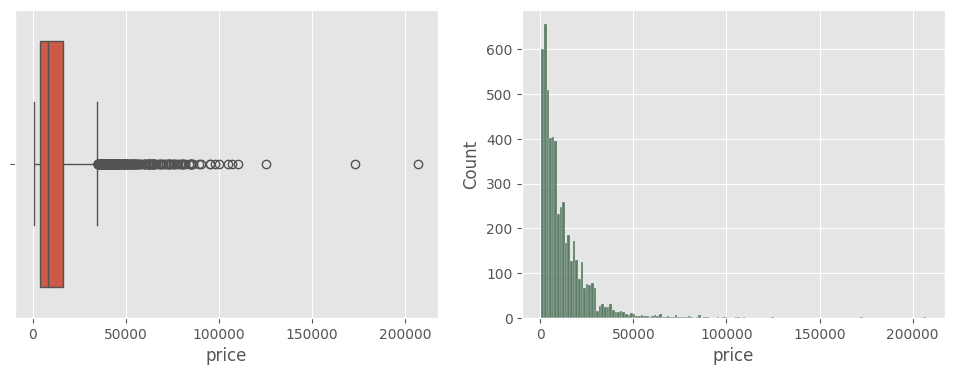

In [16]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=train_df, x='price', ax=axes[0])
sns.histplot(data=train_df, x='price', color='#2D5A3CFF', ax=axes[1])

Both boxplot and histogram show that majority of the data points for 'price' are in the range of (0, 50000). The distribution is heavily right skewed.

In [17]:
skew_value = skew(train_df['price'], bias=True)
print(f'The skewness value for price is {skew_value:.3f}')

The skewness value for price is 3.412


### Extremes

No of points greater than 50K

In [18]:
extremes = train_df[train_df['price']>50000][['price', 'car_make']]
print(f'The no of points greater than 50K is {len(extremes)}, which is {len(extremes)/len(train_df):.2f}% of total points.')

The no of points greater than 50K is 93, which is 0.02% of total points.


Distribution of extremes

<Axes: xlabel='price', ylabel='car_make'>

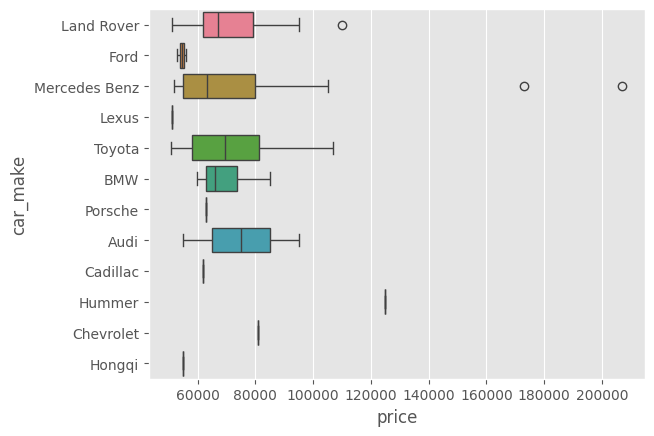

In [19]:
sns.boxplot(data=extremes, x='price', y='car_make', hue='car_make', orient='h')

### Price by Car Makers

<Axes: xlabel='price', ylabel='car_make'>

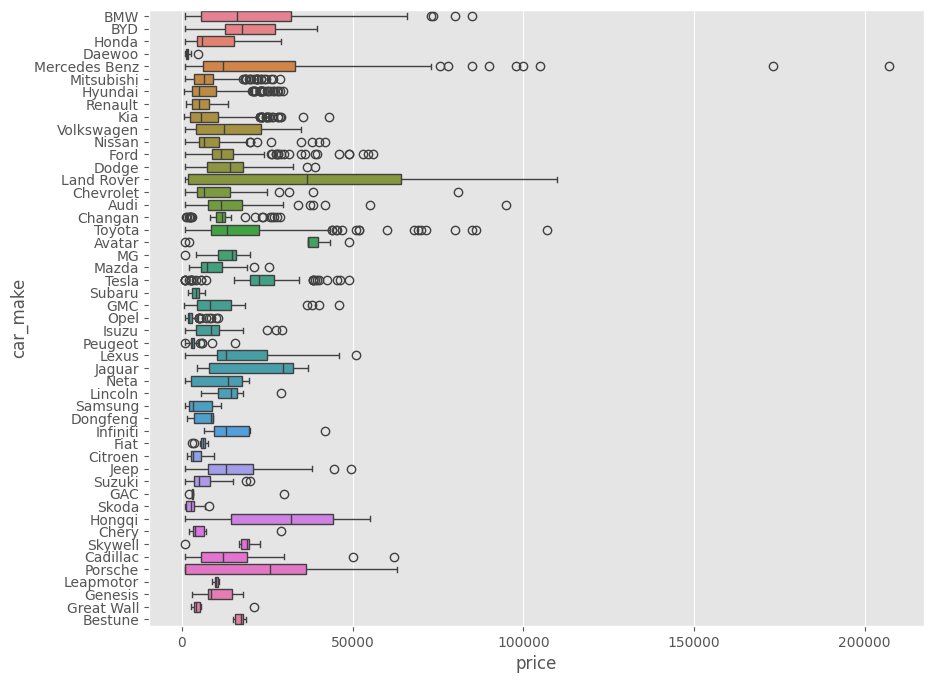

In [20]:
min_count = 5
car_makers_w_min_count = train_df['car_make'].value_counts().reset_index()
car_makers_w_min_count = car_makers_w_min_count[car_makers_w_min_count['count'] > min_count]['car_make']
df = train_df[train_df['car_make'].isin(car_makers_w_min_count)][['car_make', 'price']]
plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='price', y='car_make',hue='car_make', orient='h')

For most of the Car Makers, the distribution of price points is narrow which will help in predicting the price with high confidence except few like Porsche, Hongqi, Jaguar, and Land Rover.

For Toyota, Audi, Chevrolet, Mercedes Benz, and BMW, the majority of the price points still fall under a narrow distribution with few outliers - which needs to be studied. My hypothesis is these outliers belong to models in the Sportscar segment. 

### Drill down to Model

<Axes: xlabel='price', ylabel='model'>

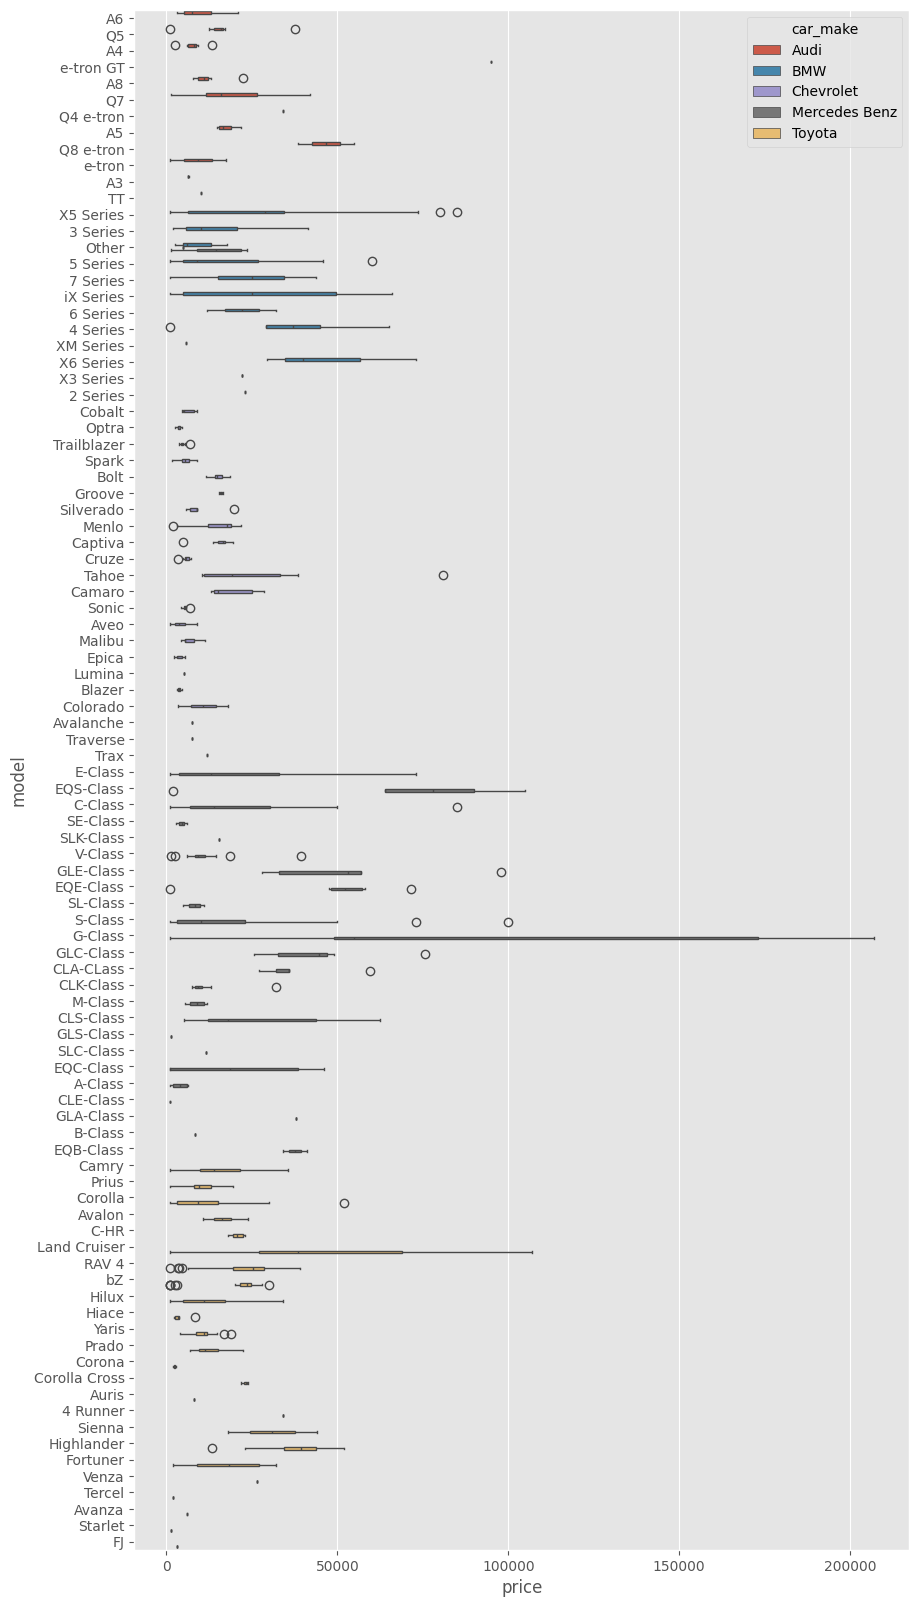

In [21]:
car_makers = ['Toyota', 'Audi', 'Chevrolet', 'Mercedes Benz', 'BMW']
df = train_df[train_df['car_make'].isin(car_makers)][['car_make','model', 'price']]
df.sort_values(by='car_make', inplace=True)
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x='price', y='model', hue='car_make', orient='h')

This plot tells us clearly which models have outliers.

Checking few cars with outliers

In [22]:
# train_df[train_df['model']=='Tahoe']
# train_df[train_df['model']=='Land Cruiser'].sort_values(by='price', ascending=False)
train_df[train_df['model']=='G-Class'].sort_values(by='price', ascending=False)

,id,scraped_time,condition,car_make,model,trim,year,kilometers,body_type,num_of_seats,...,neighborhood,category,subcategory,interior_options,exterior_options,technology_options,description_score,battery_capacity,battery_range,price
3064,3065,2025-02-07 13:31:26,New,Mercedes Benz,G-Class,G 500,2021,0,SUV,5,...,Wadi Saqra,Cars and Bikes,Cars For Sale,"Steering Wheel Controls, Memory Seats, CD play...","Spare Tyre, Xenon Lights, Rim Wheels, Panorami...","Blind Spot Alert, Hud Projector, Apple CarPlay...",NaN,NaN,NaN,207000.0
1400,1401,2025-02-07 12:56:08,Used,Mercedes Benz,G-Class,G 500,2020,"30,000 - 39,999",SUV,5,...,Deir Ghbar,Cars and Bikes,Cars For Sale,"Electric Windows, Heated Steering Wheel, Leath...","Back Hook, Sunroof, Xenon Lights, Keyless Entr...","360° Camera, Lane Departure Alert, Blind Spot ...",NaN,NaN,NaN,173000.0
4509,4510,2025-02-07 22:12:08,Used,Mercedes Benz,G-Class,G 550,2010,"+200,000",SUV,5,...,Airport Road - Manaseer Gs,Cars and Bikes,Cars For Sale,"AUX / USB Input, Sport Seats, Electric Seat Co...","Front Sensors, Rear Sensors, Sunroof, Electric...",Android Auto,فحص كامل,NaN,NaN,55000.0
3450,3451,2025-02-07 11:12:33,Used,Mercedes Benz,G-Class,G 500,2009,"+200,000",SUV,5,...,Deir Ghbar,Cars and Bikes,Cars For Sale,"CD player, Leather Seats, AUX / USB Input, Air...","Rear Sensors, Sunroof, Electric Mirrors, Xenon...","Traction Control, Bluetooth, ABS Brakes, Media...",4,NaN,NaN,49000.0
1882,1883,2025-02-06 22:26:56,Used,Mercedes Benz,G-Class,G 63 AMG,2014,"130,000 - 139,999",SUV,5,...,Wadi Saqra,Cars and Bikes,Cars For Sale,"Airbags, Cooled Seats, Electric Seat Control, ...","Electrically Folding Mirrors, Daytime Running ...","Media Screen, ABS Brakes, Rear Camera, Tractio...",NaN,NaN,NaN,1000.0


id - 5732 - New, 0 km - $1000 - seems incorrect

There seem to be lot of such errors/outliers across combination of all features.

Rows with price as $1000 may be an issue.

## Preprocessor

In [32]:
drop_features = ['id', 'scraped_time', 'category', 'subcategory', 'description_score']
options_features = ['interior_options', 'exterior_options', 'technology_options']
cat_features_imp_zero = ['trim', 'battery_capacity', 'battery_range', 'neighborhood']
cat_features_imp_freq = ['condition', 'car_make', 'model',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission', 
       'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city']

In [33]:
len(drop_features + options_features + cat_features_imp_freq + cat_features_imp_zero)

30

In [34]:
cat_impute_freq_pipeline = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_to_str', FunctionTransformer(convert_to_str)),
    ('freq_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=5))
])

In [35]:
cat_impute_zero_pipeline = Pipeline(steps=[
    ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('zero_to_str', FunctionTransformer(convert_to_str)),
    ('zero_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, min_frequency=5))
])

In [36]:
preprocessor = ColumnTransformer(transformers=[
    ('cat_impute_freq', cat_impute_freq_pipeline, cat_features_imp_freq),
    ('cat_impute_zero', cat_impute_zero_pipeline, cat_features_imp_zero),
    ('engine_size', EngineSizeTransformer(), ['engine_size_cc']),
    ('year', YearTransformer(), ['year']),
    ('multi_options', MultiLabelBinarizerTransformer(columns=options_features), options_features),
    ('drop', 'drop', drop_features)
], remainder='passthrough')

In [37]:
train_df_transformed = preprocessor.fit_transform(train_df)
train_df_transformed.shape

(5399, 742)

In [38]:
train_trf_array = train_df_transformed.toarray()
sparsity = np.sum(train_trf_array == 0) / train_trf_array.size
print(f'The sparsity of the preprocessed train df is {sparsity:.2f}')

The sparsity of the preprocessed train df is 0.94


## Outliers using Isolation Forest

In [92]:
iso = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
outlier_preds = iso.fit_predict(train_trf_array)
np.unique(outlier_preds)

array([-1,  1])

In [93]:
np.bincount(outlier_preds+1)

array([ 540,    0, 4859])

In [102]:
train_df['outlier'] = outlier_preds

## Visualizing Outliers

<Axes: xlabel='price', ylabel='car_make'>

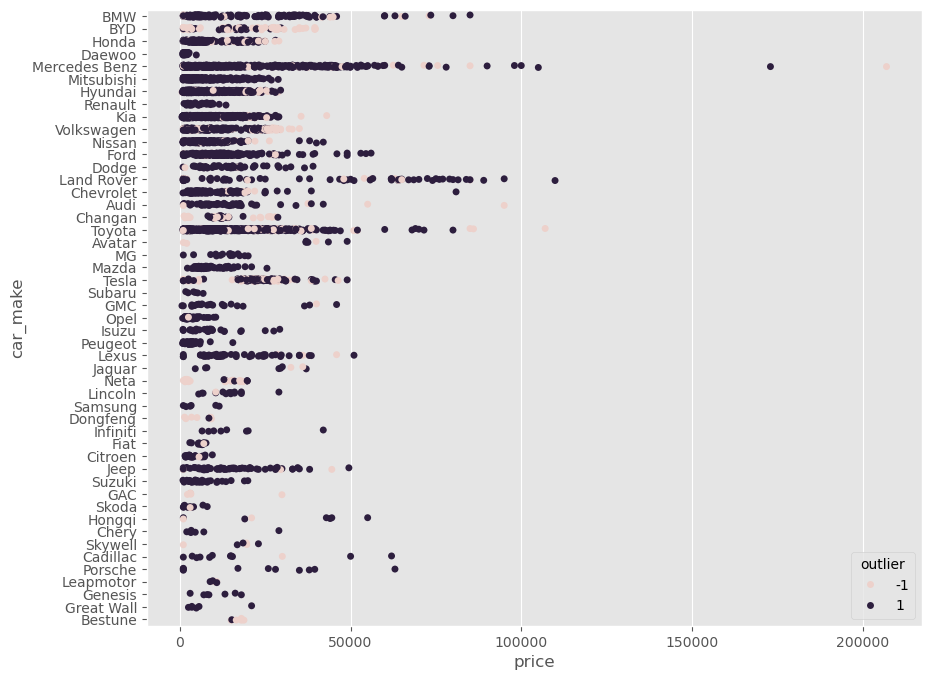

In [105]:
df = train_df[train_df['car_make'].isin(car_makers_w_min_count)][['car_make', 'model', 'price', 'outlier']]
plt.figure(figsize=(10,8))
sns.stripplot(data=df, x='price', y='car_make', hue='outlier', orient='h')

<Axes: xlabel='price', ylabel='maker_model'>

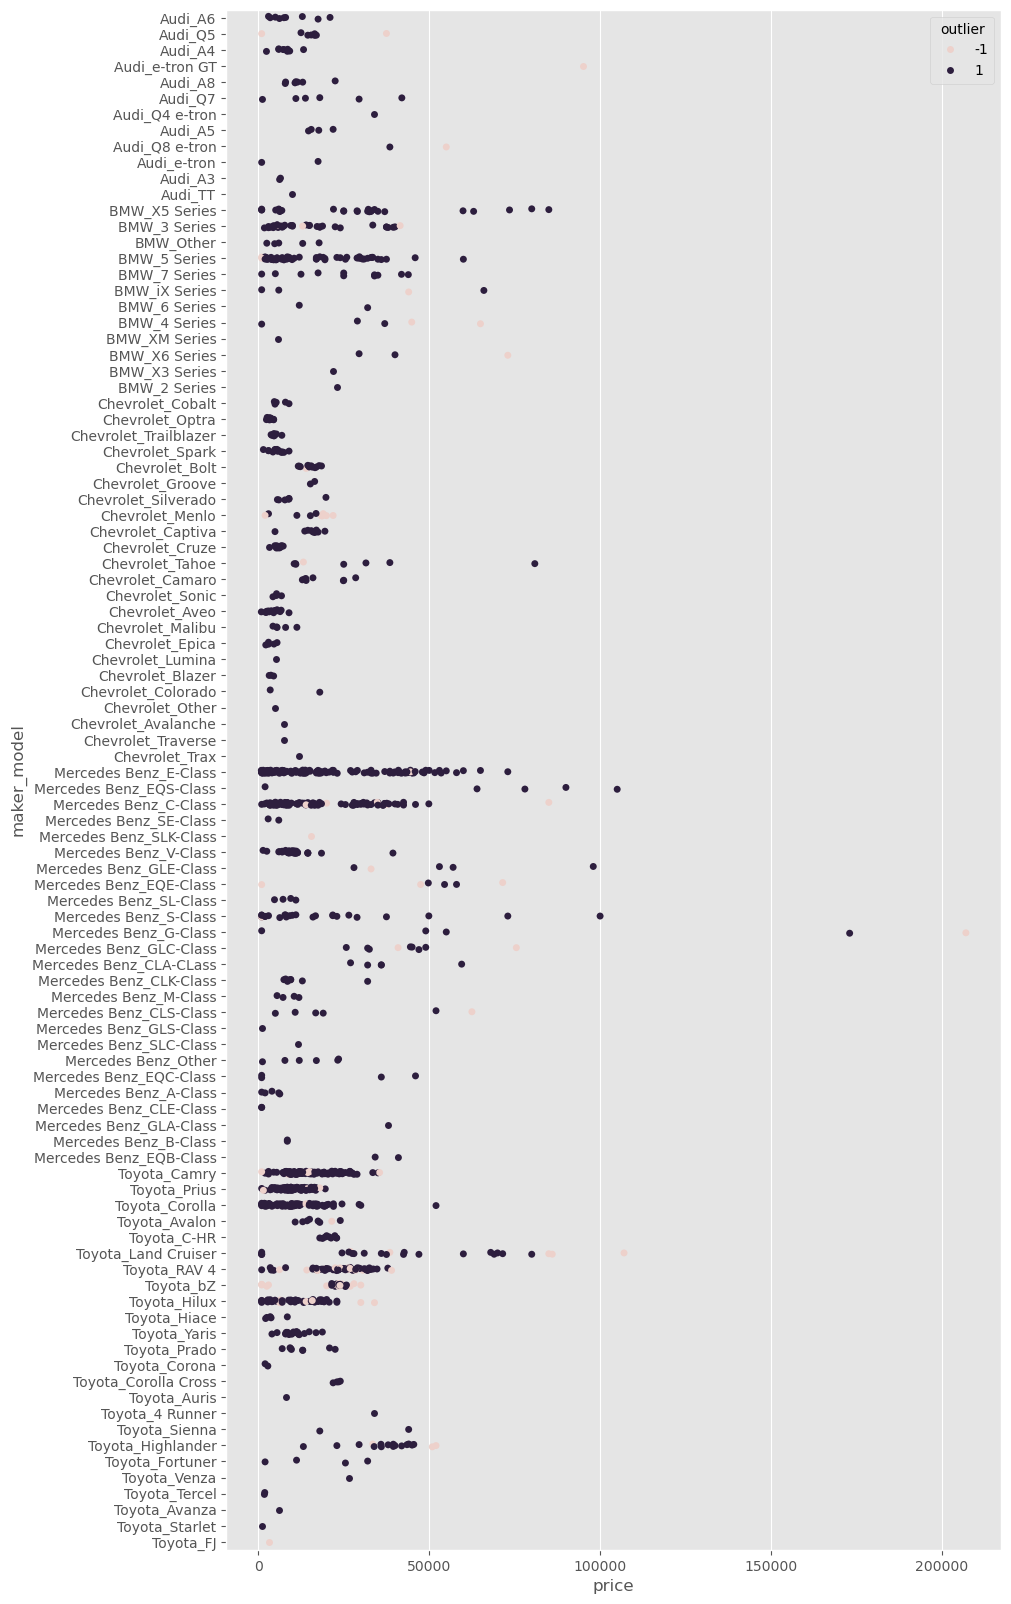

In [108]:
car_makers = ['Toyota', 'Audi', 'Chevrolet', 'Mercedes Benz', 'BMW']
df = train_df[train_df['car_make'].isin(car_makers)][['car_make', 'model', 'price', 'outlier']]
df['maker_model'] = df['car_make'] + '_' + df['model']
df.sort_values(by='car_make', inplace=True)
plt.figure(figsize=(10, 20))
sns.stripplot(data=df, x='price', y='maker_model', hue='outlier', orient='h')

# Identifying high cardinality features

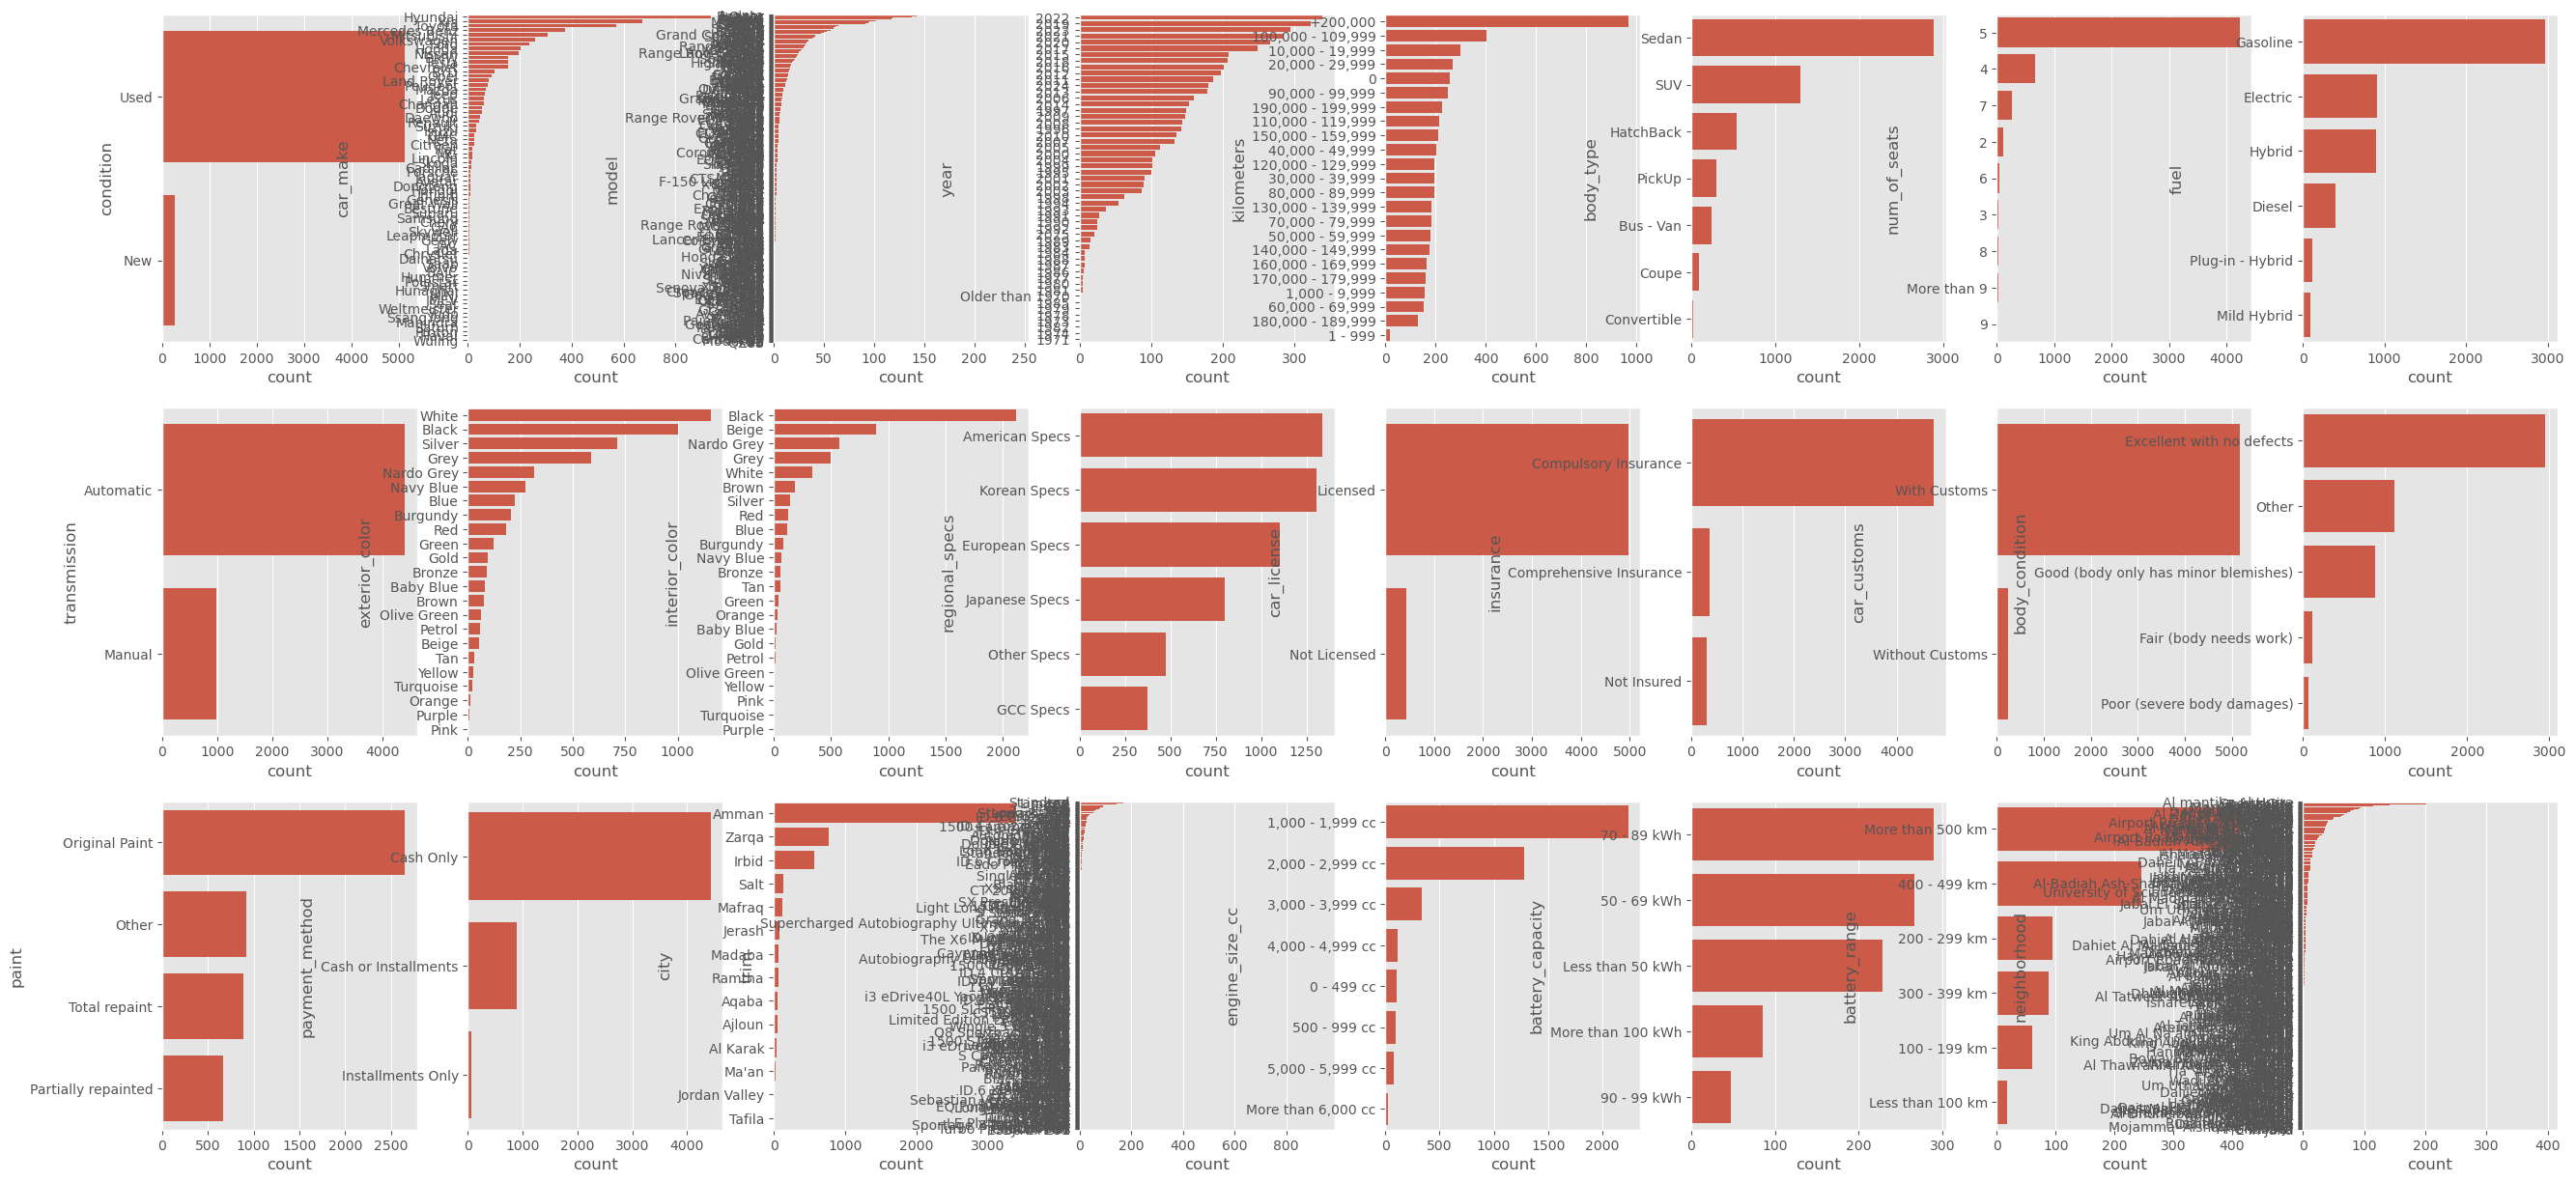

In [26]:
relevant_features = cat_features_imp_freq + cat_features_imp_zero
fig, axes = plt.subplots(3, 8, figsize=(32, 15))
axes = axes.flatten()

for ax, feature in zip(axes, relevant_features):
    counts = train_df[feature].value_counts().reset_index()
    sns.barplot(data=counts, y=feature, x='count', ax=ax)

Checking top high cardinality features

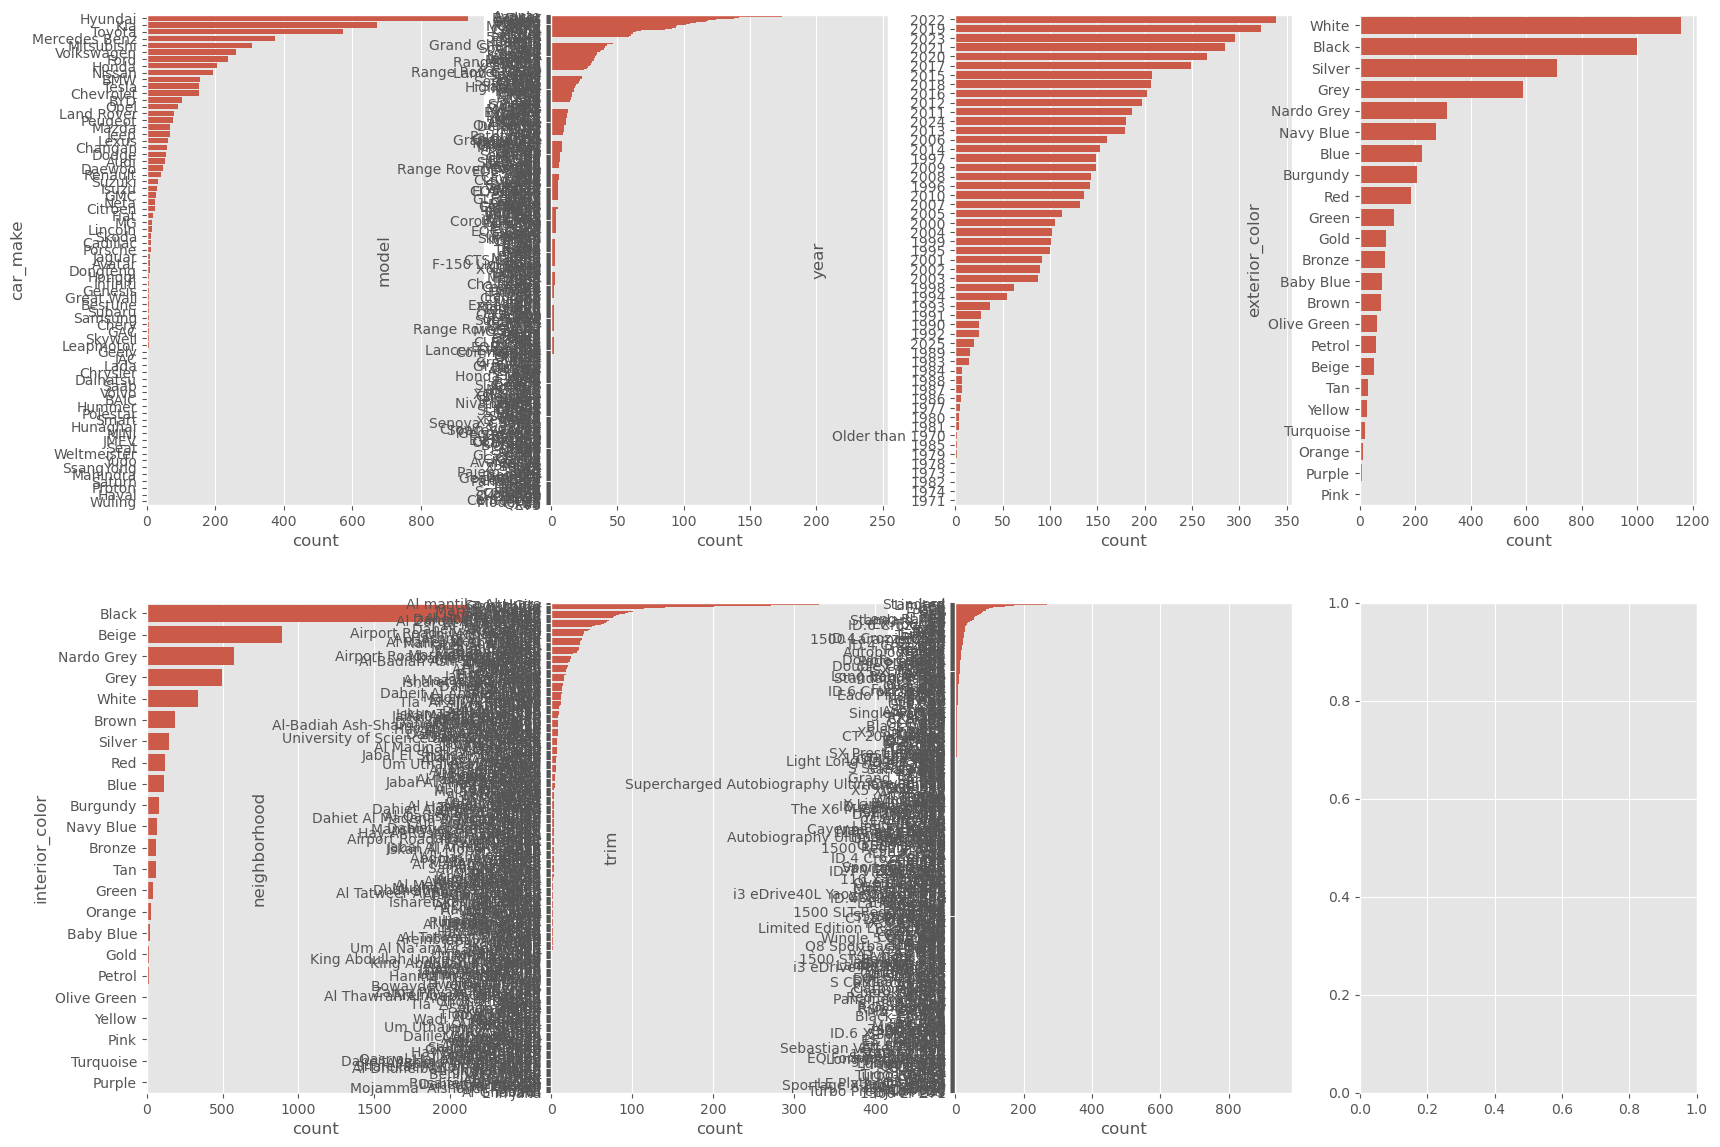

In [27]:
high_cardinality = ['car_make', 'model', 'year', 'exterior_color', 'interior_color', 'neighborhood', 'trim']
fig, axes = plt.subplots(2, 4, figsize=(20, 14))
axes = axes.flatten()

for ax, feature in zip(axes, high_cardinality):
    counts = train_df[feature].value_counts().reset_index()
    sns.barplot(data=counts, y=feature, x='count', ax=ax)

In [32]:
f'{(train_df['model'].value_counts()*100/len(train_csv)).reset_index()['count'][:200].sum():.2f} %'

'65.82 %'

# Model_2

In [257]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', TransformedTargetRegressor(
        regressor=Ridge(alpha=10),
        func=preprocessing_functions.log_transform,
        inverse_func=preprocessing_functions.exp_transform
    ))
], memory=memory)

In [258]:
ridge_model.fit(X_train, y_train)

Pipeline(memory=Memory(location=cache_dir\joblib),
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function convert_to_str at 0x000002433BB9AB60>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unkno...
                                                                                          'exterior_options',
                                                                                          'technology_options']),
                                                  ['interior_options',
                                                   'exterior_options',
                                                   'technology_options']),
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score'])])),
                ('lr',
                 TransformedTargetRegressor(func=<function log_transform at 0x000002433BB9BB00>,
                                            inverse_func=<function exp_transform at 0x000002433BBB53A0>,
                                            regressor=Ridge(alpha=10)))])

In [259]:
train_rmse = root_mean_squared_error(y_train, ridge_model.predict(X_train))
val_rmse = root_mean_squared_error(y_val, ridge_model.predict(X_val))

print(f'Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}')

Train RMSE: 9155.670, Val RMSE: 9979.606


In [260]:
train_sizes, train_scores, test_scores = learning_curve(ridge_model, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1)

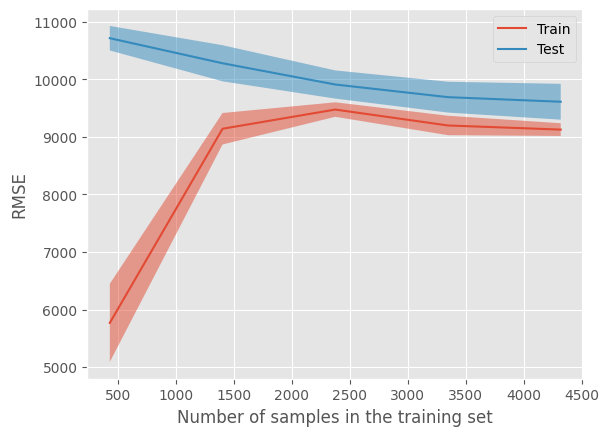

In [261]:
plt.style.use('ggplot')
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=-train_scores, test_scores=-test_scores, score_name='RMSE')
display.plot()

# Model_3

In [317]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('lr', TransformedTargetRegressor(
        regressor=Ridge(alpha=1000),
        func=preprocessing_functions.log_transform,
        inverse_func=preprocessing_functions.exp_transform
    ))
], memory=memory)

In [318]:
ridge_model.fit(X_train, y_train)

Pipeline(memory=Memory(location=cache_dir\joblib),
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function convert_to_str at 0x000002433BB9AB60>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unkno...
                                                                                          'technology_options']),
                                                  ['interior_options',
                                                   'exterior_options',
                                                   'technology_options']),
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score'])])),
                ('poly', PolynomialFeatures()),
                ('lr',
                 TransformedTargetRegressor(func=<function log_transform at 0x000002433BB9BB00>,
                                            inverse_func=<function exp_transform at 0x000002433BBB53A0>,
                                            regressor=Ridge(alpha=1000)))])

In [323]:
def bias_variance_plot(model):
    train_rmse = root_mean_squared_error(y_train, ridge_model.predict(X_train))
    val_rmse = root_mean_squared_error(y_val, ridge_model.predict(X_val))

    print(f'Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}')

    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1)

    plt.style.use('ggplot')
    display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=-train_scores, test_scores=-test_scores, score_name='RMSE')
    display.plot()

Train RMSE: 8086.787, Val RMSE: 9883.648


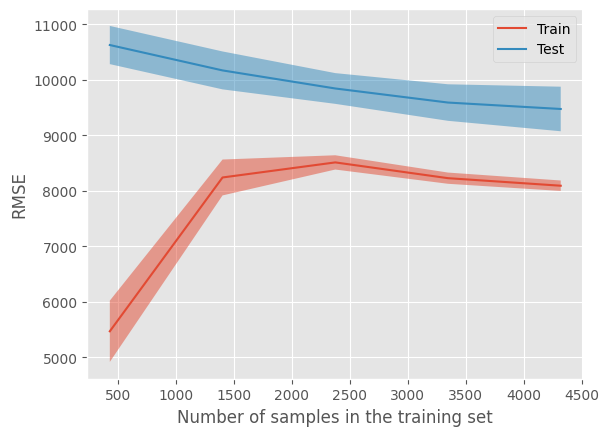

In [324]:
bias_variance_plot(ridge_model)

# SVR

In [328]:
svr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('svr', TransformedTargetRegressor(
        regressor=SVR(),
        func=preprocessing_functions.log_transform,
        inverse_func=preprocessing_functions.exp_transform
    ))
], memory=memory)

In [329]:
param_grid = {
    'svr__regressor__C': [0.1, 1, 10],
    'svr__regressor__gamma': [0.001, 0.01, 0.1]
}
grid = GridSearchCV(svr_model, 
                    param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(memory=Memory(location=cache_dir\joblib),
                                steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_impute_freq',
                                                                         Pipeline(steps=[('freq_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('freq_to_str',
                                                                                          FunctionTransformer(func=<function convert_to_str at 0x000002433BB9AB60>)),
                                                                                         ('freq_encoder...
                                                                          'subcategory',
                                                                          'description_score'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('svr',
                                        TransformedTargetRegressor(func=<function log_transform at 0x000002433BB9BB00>,
                                                                   inverse_func=<function exp_transform at 0x000002433BBB53A0>,
                                                                   regressor=SVR()))]),
             n_jobs=-1,
             param_grid={'svr__regressor__C': [0.1, 1, 10],
                         'svr__regressor__gamma': [0.001, 0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

In [334]:
print(f'Best params for SVR: {grid.best_params_}')
print(f'Best score: {grid.best_score_:.3f}')

Best params for SVR: {'svr__regressor__C': 1, 'svr__regressor__gamma': 0.001}
Best score: -8962.200


Train RMSE: 8086.787, Val RMSE: 9883.648


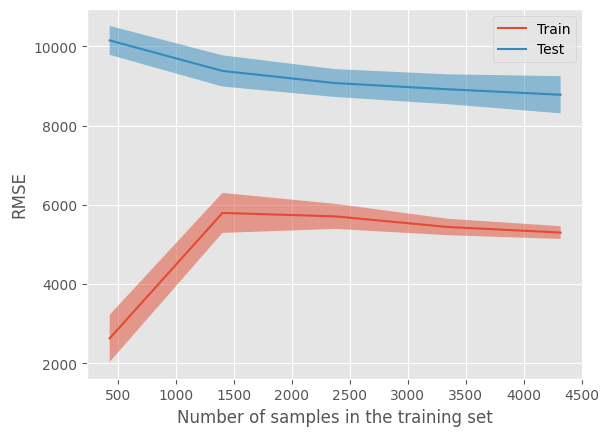

In [335]:
bias_variance_plot(grid.best_estimator_)

# Boosting Models

In [339]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('xgb', TransformedTargetRegressor(
        regressor=XGBRegressor(),
        func=preprocessing_functions.log_transform,
        inverse_func=preprocessing_functions.exp_transform
    ))
], memory=memory)

In [343]:
param_grid = {
    'xgb__regressor__eta': [0.3, 0.5, 0.8],
    'xgb__regressor__gamma': [0, 0.1],
    'xgb__regressor__max_depth': [3, 6, 10],
    'xgb__regressor__subsample': [0.5, 1],
    'xgb__regressor__n_estimators': [100]
}
grid = GridSearchCV(xgb_model, 
                    param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    cv=5,
                    verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=cache_dir\joblib),
                                steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_impute_freq',
                                                                         Pipeline(steps=[('freq_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('freq_to_str',
                                                                                          FunctionTransformer(func=<function convert_to_str at 0x000002433BB9AB60>)),
                                                                                         ('freq_encoder...
                                                                                          monotone_constraints=None,
                                                                                          multi_strategy=None,
                                                                                          n_estimators=None,
                                                                                          n_jobs=None,
                                                                                          num_parallel_tree=None, ...)))]),
             n_jobs=-1,
             param_grid={'xgb__regressor__eta': [0.3, 0.5, 0.8],
                         'xgb__regressor__gamma': [0, 0.1],
                         'xgb__regressor__max_depth': [3, 6, 10],
                         'xgb__regressor__n_estimators': [100],
                         'xgb__regressor__subsample': [0.5, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [344]:
def get_best_params_score(grid):
    print(f'Best params: {grid.best_params_}')
    print(f'Best score: {grid.best_score_:.3f}')

In [345]:
get_best_params_score(grid=grid)

Best params: {'xgb__regressor__eta': 0.3, 'xgb__regressor__gamma': 0.1, 'xgb__regressor__max_depth': 3, 'xgb__regressor__n_estimators': 100, 'xgb__regressor__subsample': 1}
Best score: -9433.859


In [346]:
print(root_mean_squared_error(y_val, grid.best_estimator_.predict(X_val)))

9958.43608399351


# Function - Get Feature Names from Preprocessor

In [ ]:
def get_feature_names(preprocessor):
    output_features = []

    for name, trf, cols in preprocessor.transformers_:
        if trf == 'drop':
            continue
        elif trf == 'passthrough':
            output_features.extend(cols)
        else:
            if hasattr(trf, 'named_steps'):
                last_step = trf.named_steps[list(trf.named_steps)[-1]]
            else:
                last_step = trf
        
        if hasattr(last_step, 'get_feature_names_out'):
            transformed_names = last_step.get_feature_names_out(cols)
        else:
            transformed_names = cols
        
        output_features.extend(transformed_names)
    
    return output_features

## Important Features

In [118]:
rf_regressor = rf_grid.best_estimator_.named_steps['rfregressor'].regressor_

In [119]:
feature_imp = rf_regressor.feature_importances_
sorted_idx = np.argsort(feature_imp)[::-1]
sorted_idx

array([ 636,  631,  635, ...,  538, 1198,  744], dtype=int64)

In [123]:
transformed_feature_names = get_feature_names(rf_grid.best_estimator_.named_steps['preprocessor'])
np.array(transformed_feature_names[::20])

array(['condition_New', 'car_make_GAC', 'car_make_Leapmotor',
       'car_make_Skoda', 'model_207', 'model_7 Series', 'model_Atto 3',
       'model_Box', 'model_CTS/Catera', 'model_Cherokee',
       'model_Crown Victoria', 'model_EQ', 'model_Escalade',
       'model_Fortuner', 'model_Grand i10', 'model_ID 3', 'model_Kicks',
       'model_Logan', 'model_Menlo', 'model_Okavango', 'model_Pregio',
       'model_Range Rover Evoque', 'model_SM5', 'model_Skyworth',
       'model_T03', 'model_UX', 'model_XLR', 'year_1977', 'year_1997',
       'year_2017', 'kilometers_150,000 - 159,999', 'num_of_seats_2',
       'exterior_color_Blue', 'interior_color_Baby Blue',
       'interior_color_Turquoise',
       'body_condition_Poor (severe body damages)', 'city_Tafila',
       'trim_1LS', 'trim_523', 'trim_Adenture', 'trim_Bora',
       'trim_CLK 200', 'trim_Coupe', 'trim_E 350e', 'trim_ESV SR',
       'trim_G 500', 'trim_GLS Plus', 'trim_GXR', 'trim_ID.7 VIZZION Pro',
       'trim_LTZ', 'trim_Linear',

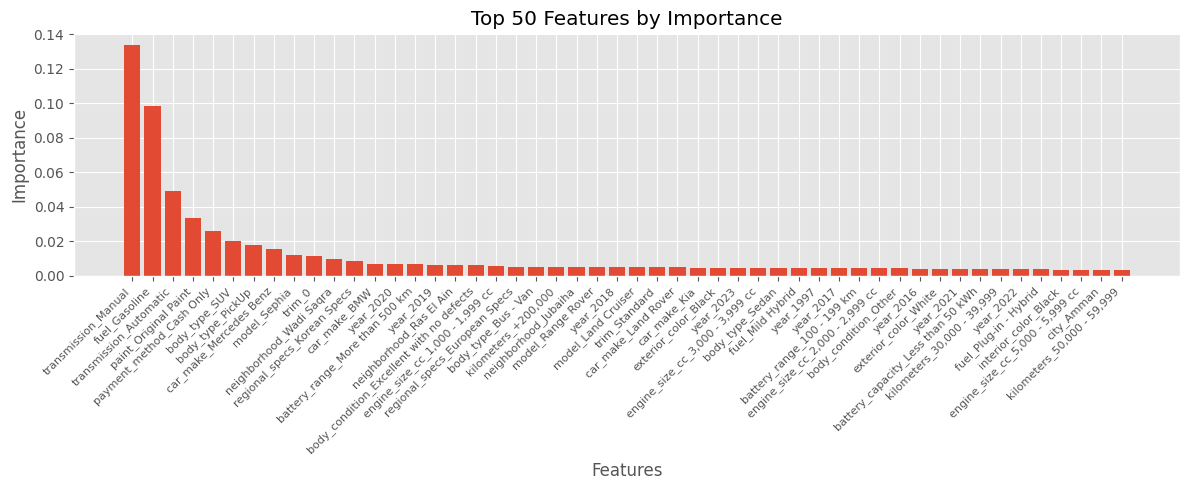

In [140]:
top_n = 50
top_features = [transformed_feature_names[i] for i in sorted_idx[:top_n]]
imp = [feature_imp[i] for i in sorted_idx[:top_n]]

fig = plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
plt.bar(top_features, imp)
plt.xlabel('Features')
plt.xticks(rotation = 45, ha='right', size=8)
plt.ylabel('Importance')
plt.title(f'Top {top_n} Features by Importance')
plt.tight_layout()

# Submission Prediction

In [181]:
rf_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001B7DA73C2C0>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition...
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score']),
                                                 ('options', 'drop',
                                                  ['interior_options',
                                                   'exterior_options',
                                                   'technology_options'])])),
                ('rfregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_features=0.9,
                                                                            min_samples_leaf=4,
                                                                            n_estimators=300,
                                                                            random_state=42)))])

In [182]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(4027, 32)

In [184]:
test_df.rename(columns=cols_map, inplace=True)

In [185]:
sub_pred = rf_model.predict(test_df)

In [190]:
sub_df = pd.DataFrame({
    'Id': test_df['id'],
    'Price': sub_pred
})

In [191]:
sub_df.to_csv('submission/sub_1_rf.csv', index=False)